In [2]:
!pip install feature_engine
!pip install catboost
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
import warnings, gc
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [3]:

data = pd.read_csv("/content/credit_risk_dataset.csv")
df=data.copy()
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df = df.drop_duplicates()

In [6]:
df = df.dropna()
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 28501
Variables: 12
cat_cols: 5
num_cols: 7
cat_but_car: 0
num_but_cat: 1


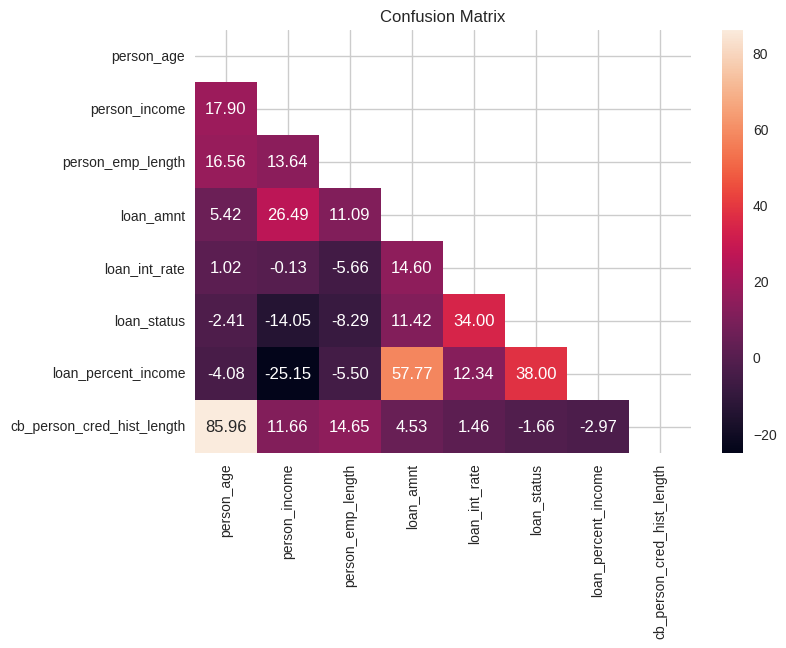

['cb_person_cred_hist_length']

In [8]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Confusion Matrix')
        plt.show()

    return drop_list

# Usage example:
high_correlated_cols(df, plot=True)

In [9]:
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12),
                           height=500, width=1000))
target=df.loan_status.value_counts(normalize=True)
target.rename(index={1:'Default',0:'non default'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45,
                     showlegend=True,sort=False,
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

In [10]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    if col != "loan_status":
      print(col, check_outlier(df, col))

person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length True


In [11]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "loan_status":
        replace_with_thresholds(df,col)

In [12]:
import plotly.tools as tls
import plotly.offline as py
df_good = df.loc[df["loan_status"] == 1]['person_age'].values.tolist()
df_bad = df.loc[df["loan_status"] == 0]['person_age'].values.tolist()
df_age = df['person_age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Loan status = 1"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Loan status = 0"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [13]:
trace0 = go.Bar(
    x = df[df["loan_status"]== 1]["person_home_ownership"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["person_home_ownership"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["loan_status"]== 0]["person_home_ownership"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["person_home_ownership"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')


In [14]:
trace0 = go.Bar(
    x = df[df["loan_status"]== 1]["loan_grade"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["loan_grade"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["loan_status"]== 0]["loan_grade"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["loan_grade"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Loan grade'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Loan grade')

In [15]:
trace0 = go.Bar(
    x = df[df["loan_status"]== 1]["loan_intent"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["loan_intent"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["loan_status"]== 0]["loan_intent"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["loan_intent"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Loan intent'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Loan intent')

<Figure size 800x550 with 0 Axes>

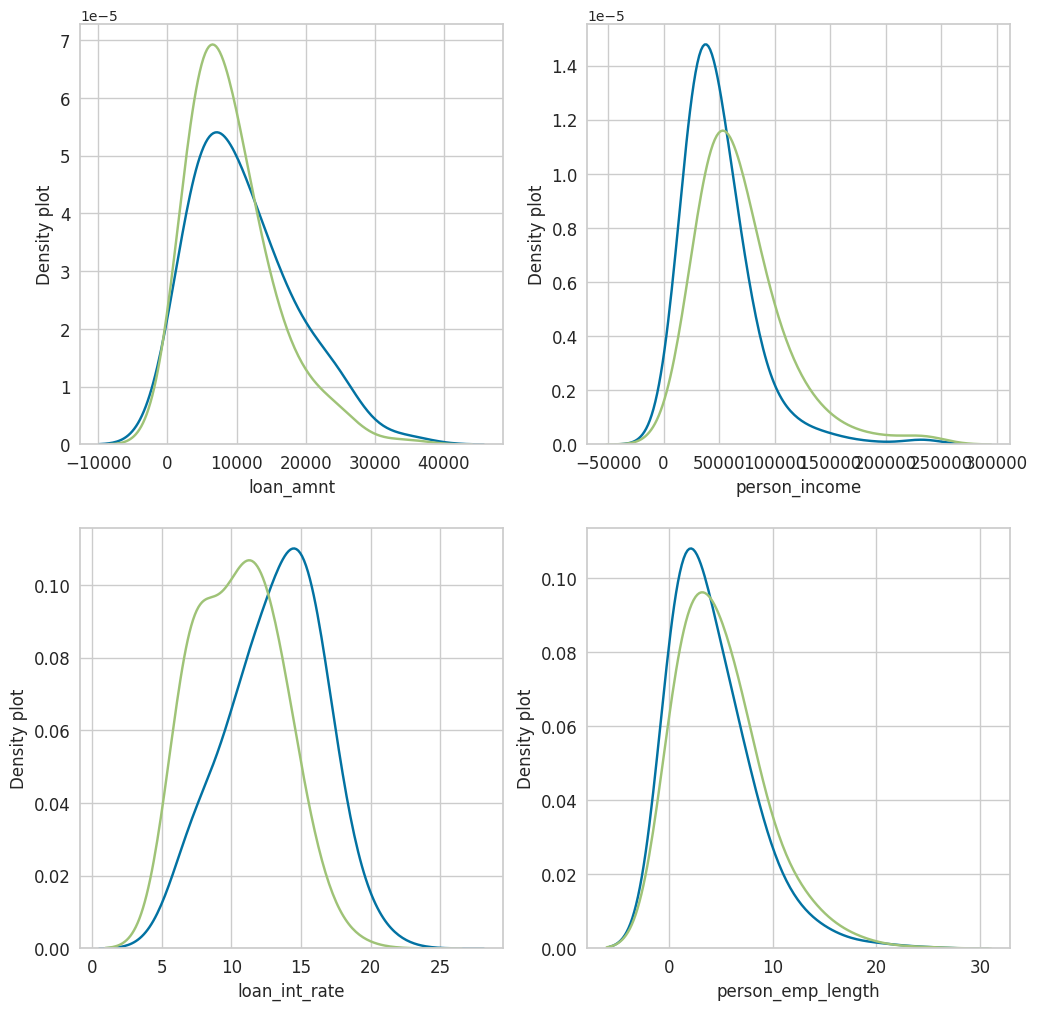

In [16]:
def plot_distribution_comp(var,nrow=2):

    i = 0
    t1 = df.loc[df['loan_status'] != 0]
    t0 = df.loc[df['loan_status'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
var = ['loan_amnt','person_income','loan_int_rate', 'person_emp_length']
plot_distribution_comp(var,nrow=2)

In [17]:
df['income_group'] = pd.cut(df['person_income'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

In [18]:
dfx=df.copy()
cat_cols, cat_but_car, num_cols = grab_col_names(dfx) # değişkenlerin son durumda sayısal ve kategorik olark durumlarını güncelliyoruz
cat_cols.remove("loan_status")


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first,dtype=int)
    return dataframe

dfx = one_hot_encoder(dfx, cat_cols, drop_first=True)

Observations: 28501
Variables: 13
cat_cols: 6
num_cols: 7
cat_but_car: 0
num_but_cat: 2


In [19]:
X = dfx.drop(['loan_status',"person_age","person_income"], axis=1)
y = dfx['loan_status']

In [20]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(28501, 24)

In [21]:
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 22313, 0: 22313})


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)
scaled_test_X = scaler.transform(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.98      0.92      0.95      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


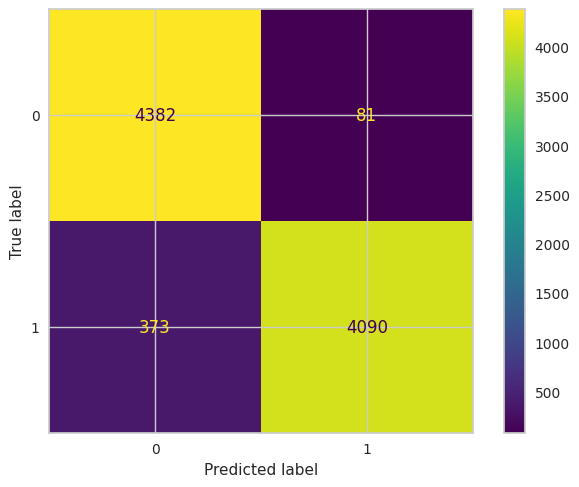

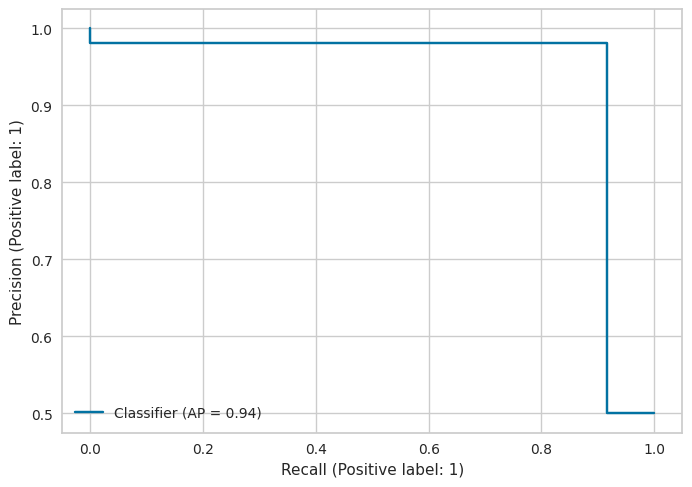

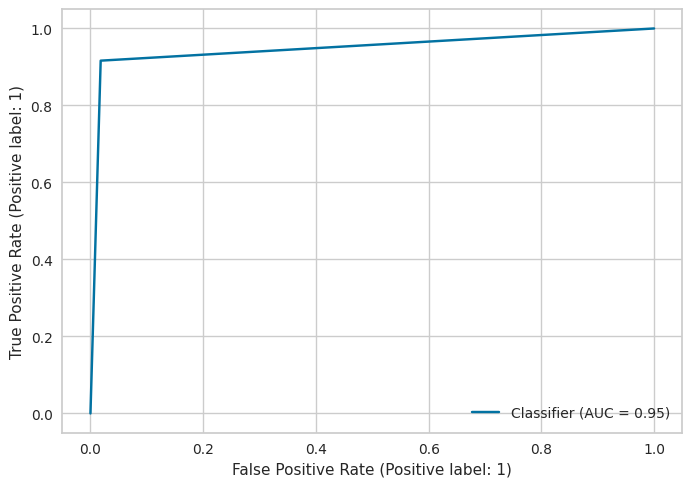

In [23]:
import re
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def train_and_evaluate_model(model):
    model.fit(scaled_train_X,y_train)
    y_pred = model.predict(scaled_test_X)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')

    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(scaled_test_X,y_test)
        visualizer.show()
        del visualizer

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()
train_and_evaluate_model(CatBoostClassifier(silent=True))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.98      0.91      0.94      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


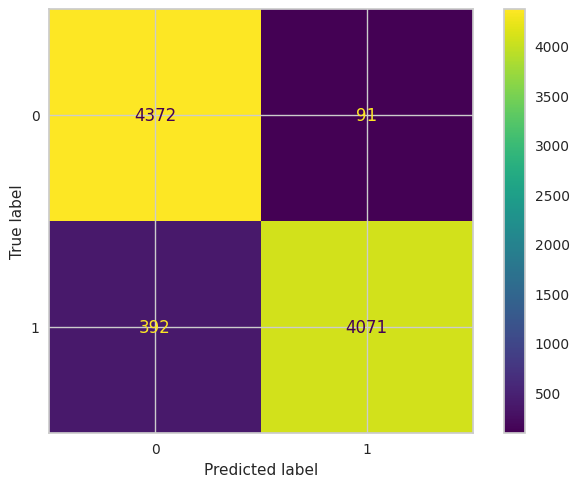

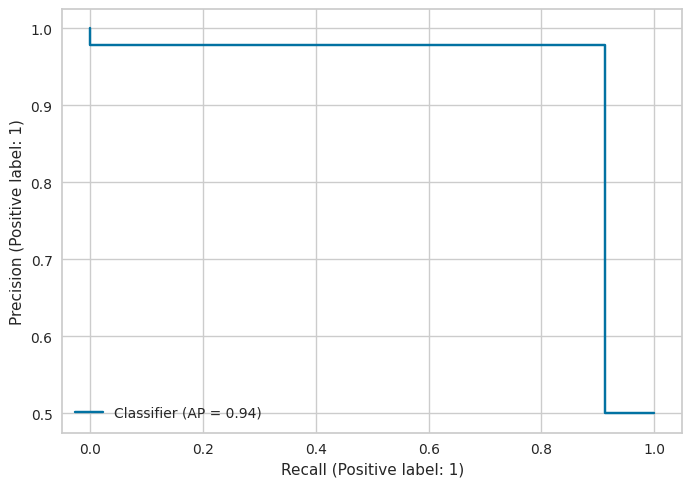

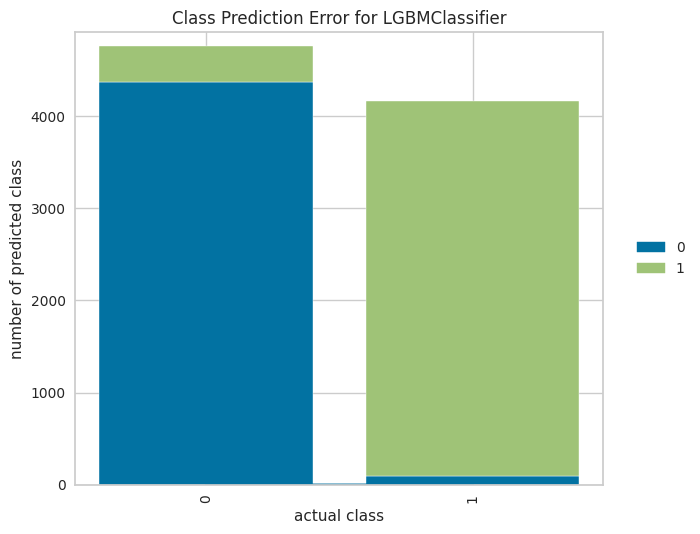

In [24]:
train_and_evaluate_model(LGBMClassifier(verbose=-1))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4463
           1       0.96      0.92      0.94      4463

    accuracy                           0.94      8926
   macro avg       0.94      0.94      0.94      8926
weighted avg       0.94      0.94      0.94      8926

--------------------------------------------------


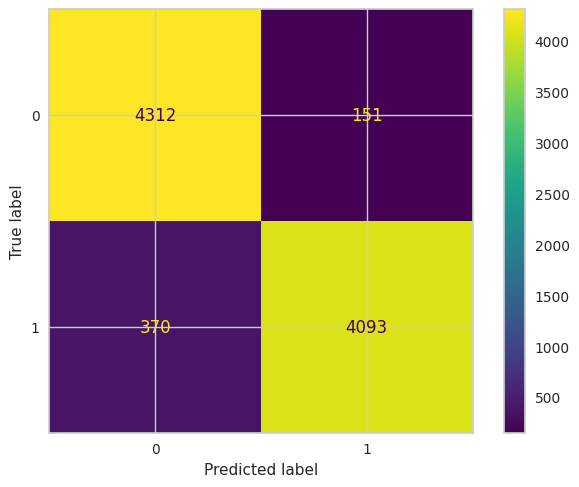

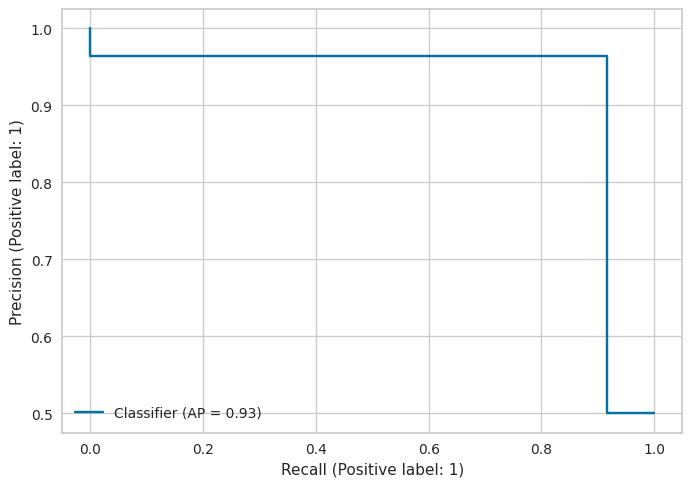

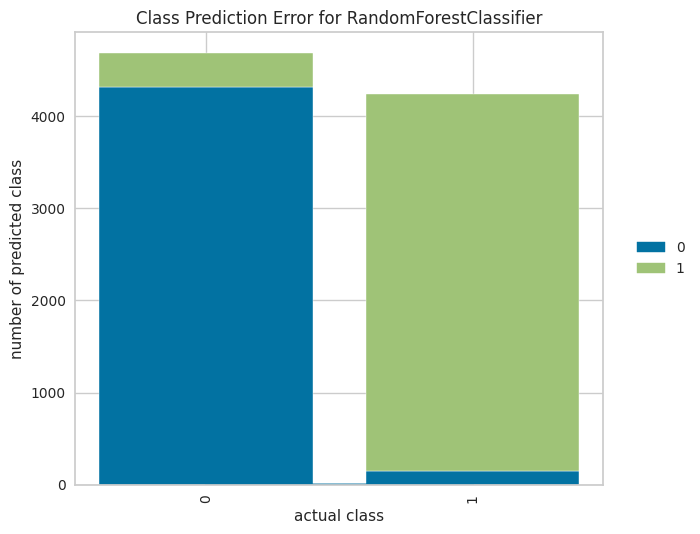

In [25]:
from sklearn.ensemble import RandomForestClassifier
train_and_evaluate_model(RandomForestClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4463
           1       0.97      0.92      0.94      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


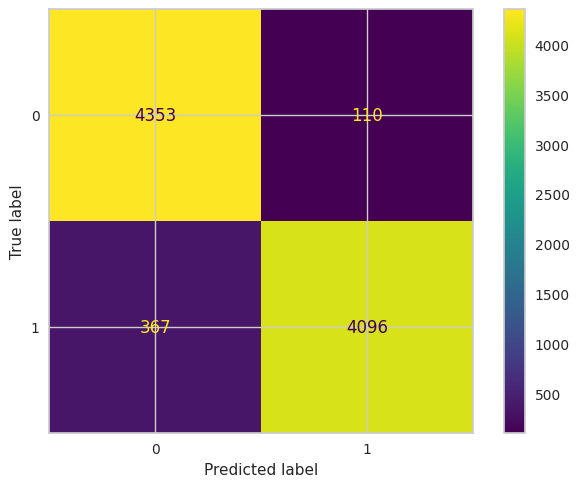

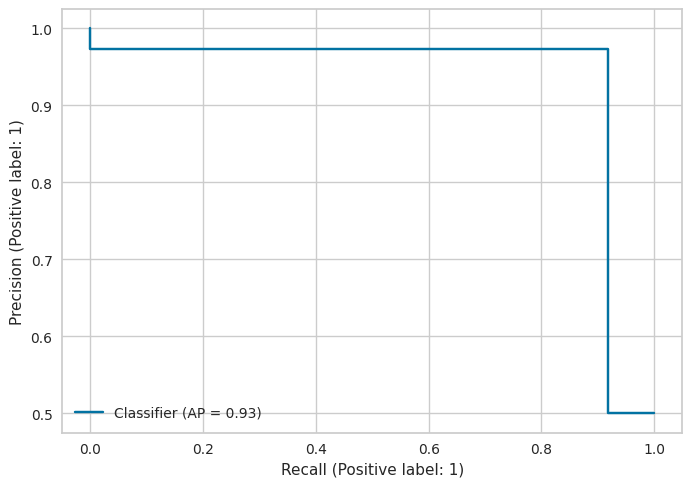

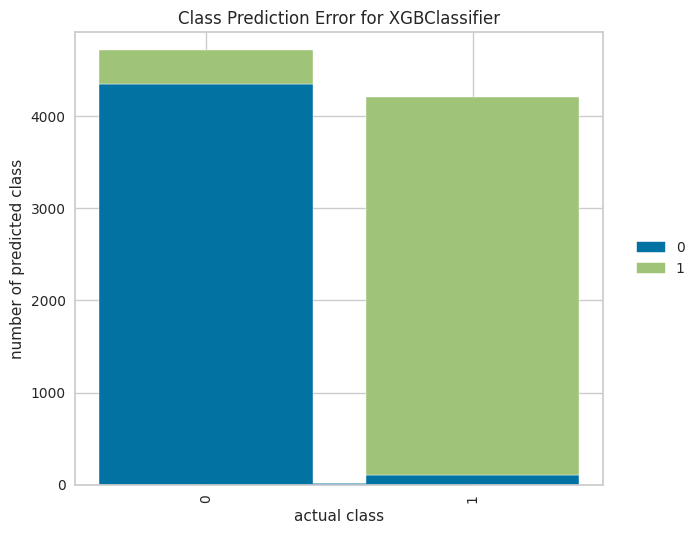

In [26]:
train_and_evaluate_model(XGBClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4463
           1       0.98      0.92      0.95      4463

    accuracy                           0.95      8926
   macro avg       0.95      0.95      0.95      8926
weighted avg       0.95      0.95      0.95      8926

--------------------------------------------------


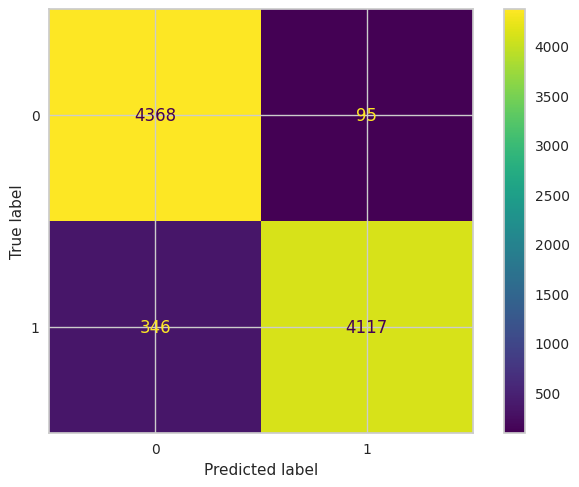

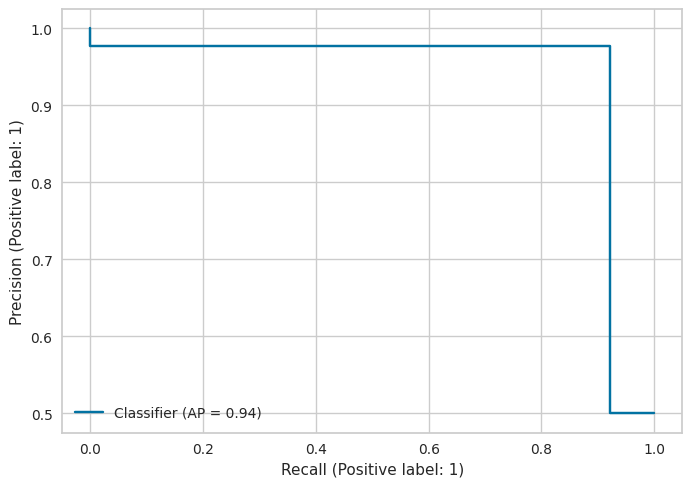

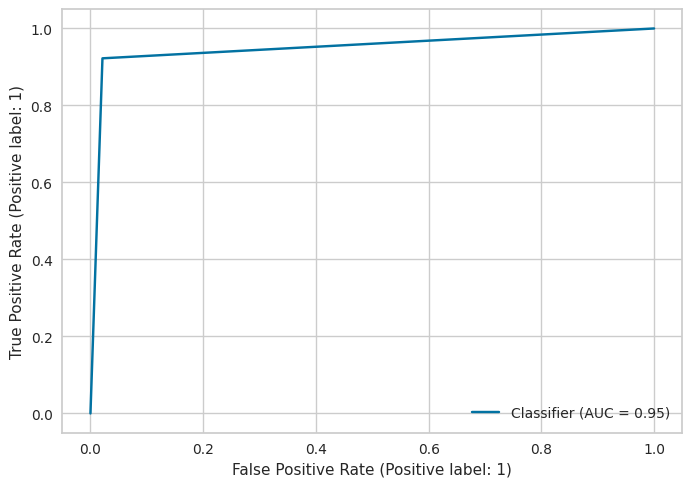

In [27]:
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier

train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],final_estimator=RandomForestClassifier(),verbose=2))

In [28]:
model_perfs = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,"StackingClassifier(estimators=[('ET', ExtraTre...",0.950594,0.952024,0.950594,0.950555,0.950594
1,<catboost.core.CatBoostClassifier object at 0x...,0.949137,0.951068,0.949137,0.949083,0.949137
2,"XGBClassifier(base_score=None, booster=None, c...",0.946561,0.948046,0.946561,0.946516,0.946561
3,LGBMClassifier(verbose=-1),0.945888,0.947926,0.945888,0.945827,0.945888
4,"(DecisionTreeClassifier(max_features='sqrt', r...",0.941631,0.942697,0.941631,0.941596,0.941631


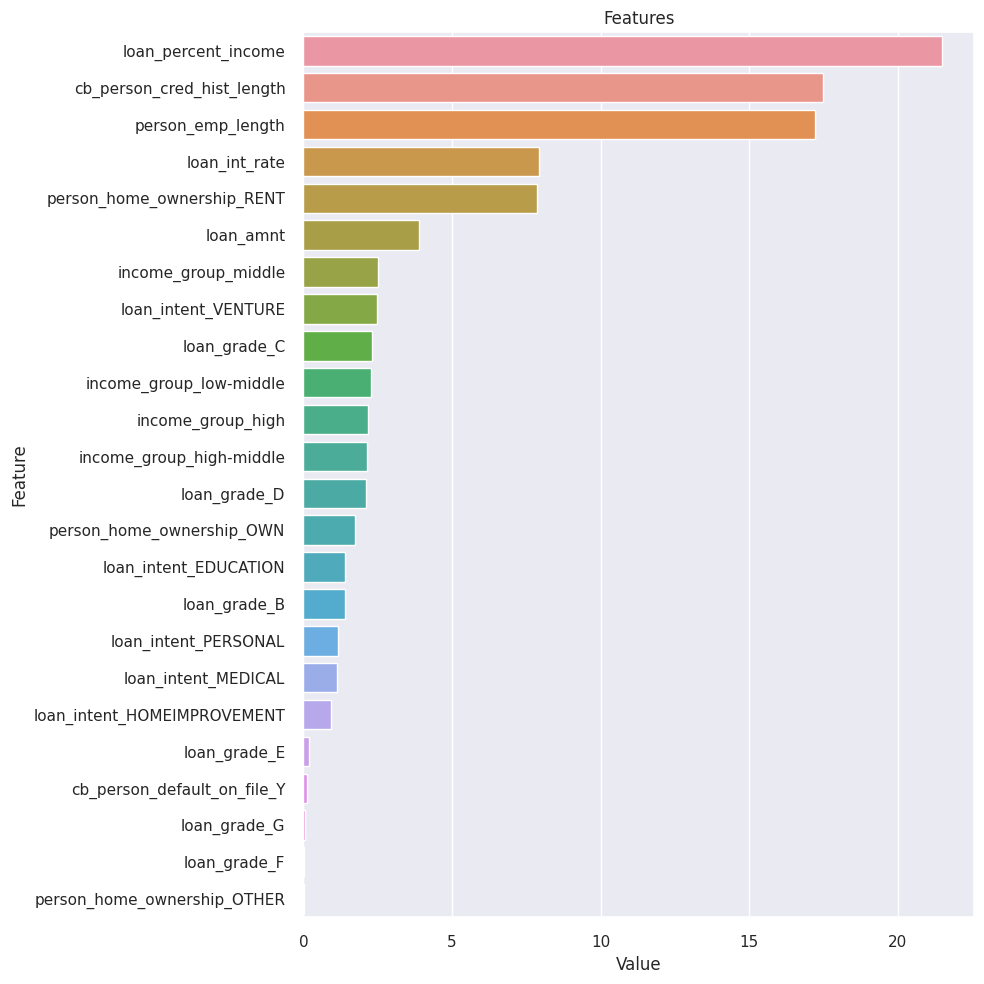

In [29]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = CatBoostClassifier(silent=True)
model.fit(X, y)

plot_importance(model, X)